# 1. Data and Library Load

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

Looking in links: file:///kaggle/input/pip-packages-icr/pip-packages
Processing /kaggle/input/pip-packages-icr/pip-packages/tabpfn-0.1.9-py3-none-any.whl


In [2]:
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform


import pickle
import os
import random
from tqdm.auto import tqdm

# ignore warning
import warnings
warnings.filterwarnings("ignore")


# ML
from sklearn.ensemble import RandomForestClassifier  # Bagging
from xgboost.sklearn import XGBClassifier            # GBM
from lightgbm.sklearn import LGBMClassifier          # lightGBM
from sklearn.metrics import accuracy_score



# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# DL
import tensorflow as tf
from tabpfn import TabPFNClassifier #Tabpfn


# for checking multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : for optuna
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from functools import partial
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier


# AutoML framework
import optuna
from optuna.samplers import TPESampler

In [4]:
# set configs
is_tuning = True
if is_tuning:
    sampler = TPESampler(seed=42)  # Make the sampler behave in a deterministic way.
    n_trials= 50

is_scaling = True
apply_vif = False # 어찌보면 원래 feature selection 일종
is_pca = False
is_pca_2 = False  # only for visualization of EDA
feature_selection = False
feature_selection_2_1 = True 
feature_selection_2_2 = False
feature_selection_3 = False
outliner = False

if feature_selection:
    m = 20


sampling_method = 'hybrid' # 'under' or 'over' or 'hybrid'
is_shuffle = True
is_tab = True
    
K = 10

In [5]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything()

In [6]:
def balance_logloss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    y_pred /= np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
    
    logloss = (-1/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - 1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / 2
    
    return logloss

In [7]:
def boxplots(df):
    cols = df.columns[1:-1]
    n = (len(cols) - 1) // 6 + 1
    m = min(len(cols), 6)
    
    palette = sns.color_palette("Set3", len(cols))
    palette_colors = [tuple(palette[i]) for i in range(len(cols))]
    
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15, 30))
    for idx, col in enumerate(cols):
        i = idx // m
        j = idx % m
        if df[col].dtype == 'object':
            sns.countplot(data=df, x=col, ax=axes[i][j], palette=[palette_colors[idx]])
        else:
            sns.boxplot(data=df, x=col, ax=axes[i][j], palette=[palette_colors[idx]])
    
    plt.tight_layout()
    plt.show()

   #i = idx // m, j = idx % m: 현재 반복문에서 처리하는 막대 그래프가 어느 위치에 그려져야 하는지 결정합니다. 이를 통해 i값에 따라 subplot 좌표를 결정합니다.

In [8]:
# creating a function for outlier detection

out = []
def ZRscore_outlier(df):
    med = np.median(df)
    ma = stats.median_abs_deviation(df)
    for i in df: 
        z = (0.6745*(i-med))/ (np.median(ma))
        if np.abs(z) > 3: 
            out.append(i)

In [9]:
train = pd.read_csv('../input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('../input/icr-identify-age-related-conditions/test.csv')
greeks = pd.read_csv('../input/icr-identify-age-related-conditions/greeks.csv')
print(train.shape, test.shape, greeks.shape)

(617, 58) (5, 57) (617, 6)


# 2. EDA

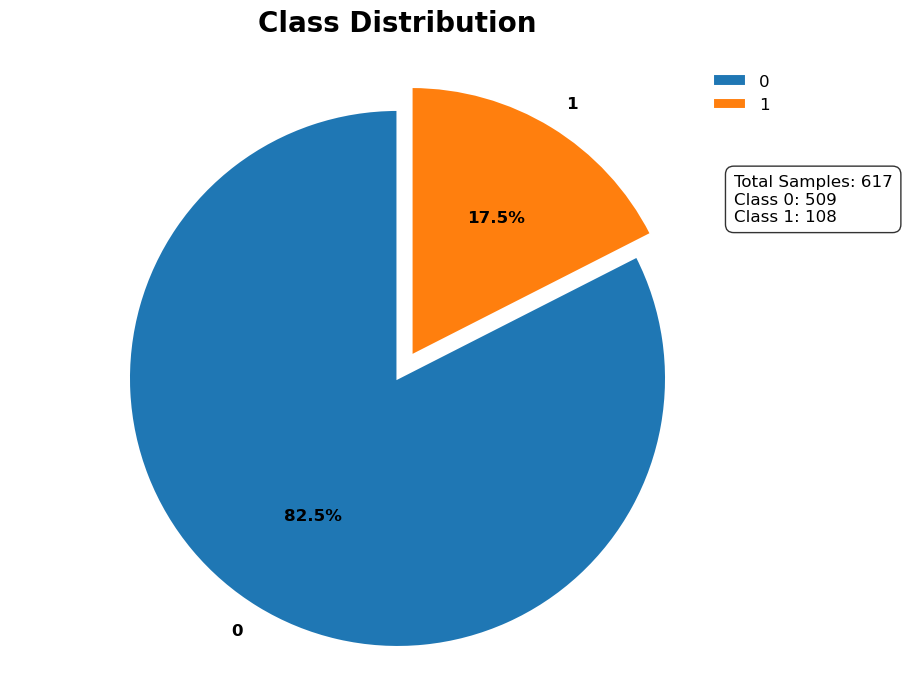

In [10]:
class_counts = train.Class.value_counts()
class_labels = class_counts.index

explode = (0.1,0)
textprops = {'fontsize':12, 'fontweight':'bold'}

fig, ax = plt.subplots(figsize=(10,8))
wedges, texts, autotexts = ax.pie(class_counts, labels=class_labels,
                                 autopct='%1.1f%%', startangle=90,
                                 explode=explode, textprops=textprops,
                                 wedgeprops={'edgecolor':'white', 'linewidth':1.5})
plt.axis('equal')
plt.title('Class Distribution', fontsize=20, fontweight='bold', pad=20)
plt.legend(loc='upper right', fontsize=12, frameon=False)

label_y = 0.5
label_x = 1.2
label_text = 'Total Samples: {}\nClass 0: {}\nClass 1: {}'.format(sum(class_counts), class_counts[0], class_counts[1])
ax.text(label_x, label_y, label_text, fontsize=12, bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))
plt.show()

In [11]:
num_features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ',
                      'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ',
                      'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ',
                      'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
                      'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU',
                      'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS',
                      'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
cat_features = ['EJ']
features = num_features + cat_features

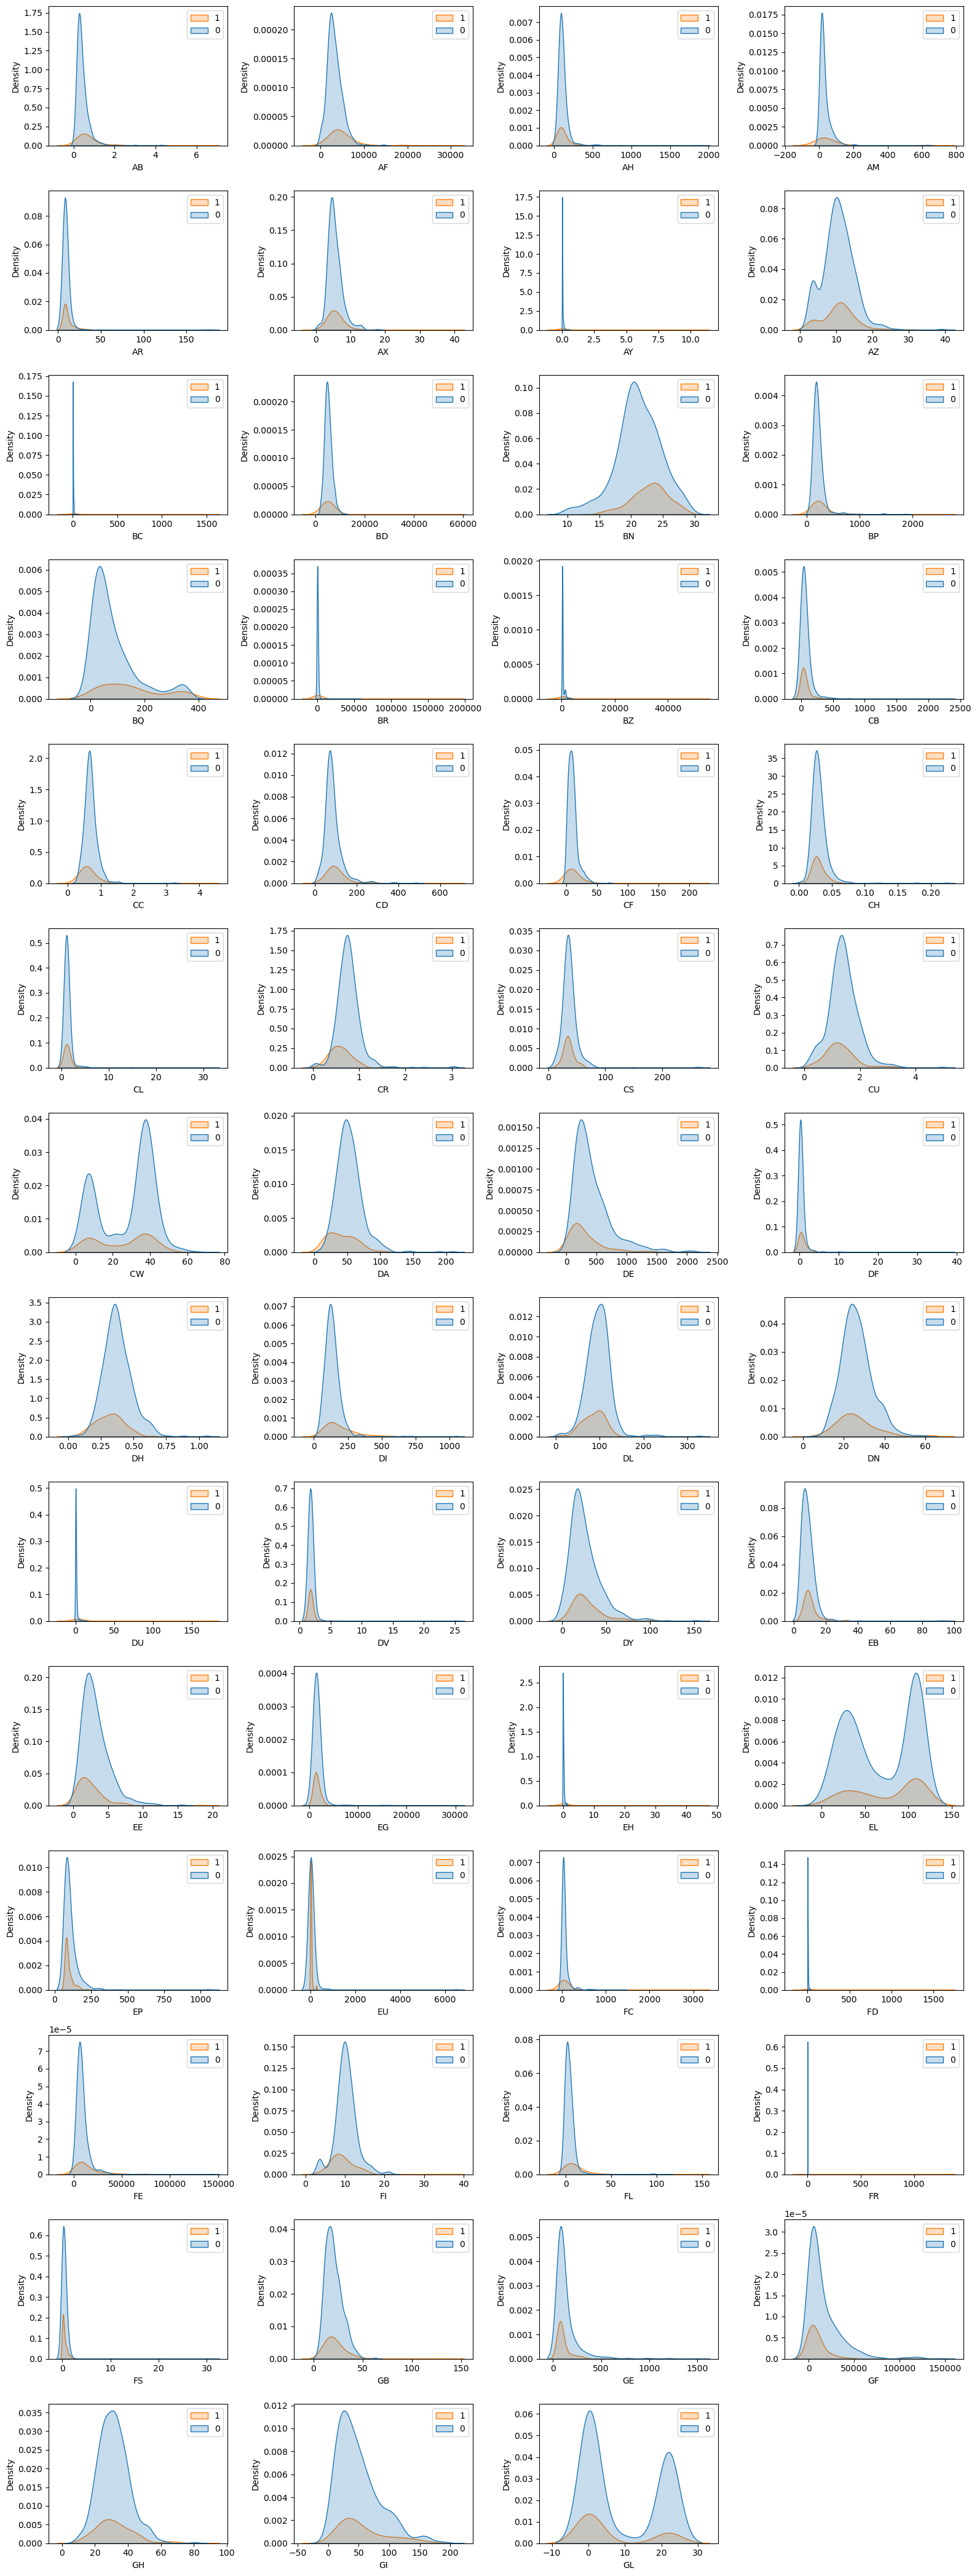

In [12]:
num_plots = len(num_features)
num_cols = 4  # Number of columns in the grid
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 3 * num_rows))
for i, feature in enumerate(num_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.kdeplot(data=train, x=feature, hue='Class', fill=True, ax=ax)
    ax.set_xlabel(feature)
    classes = train['Class'].unique()
    legend_labels = [str(c) for c in classes]
    ax.legend(labels=legend_labels)
    
if num_plots < num_rows * num_cols:
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

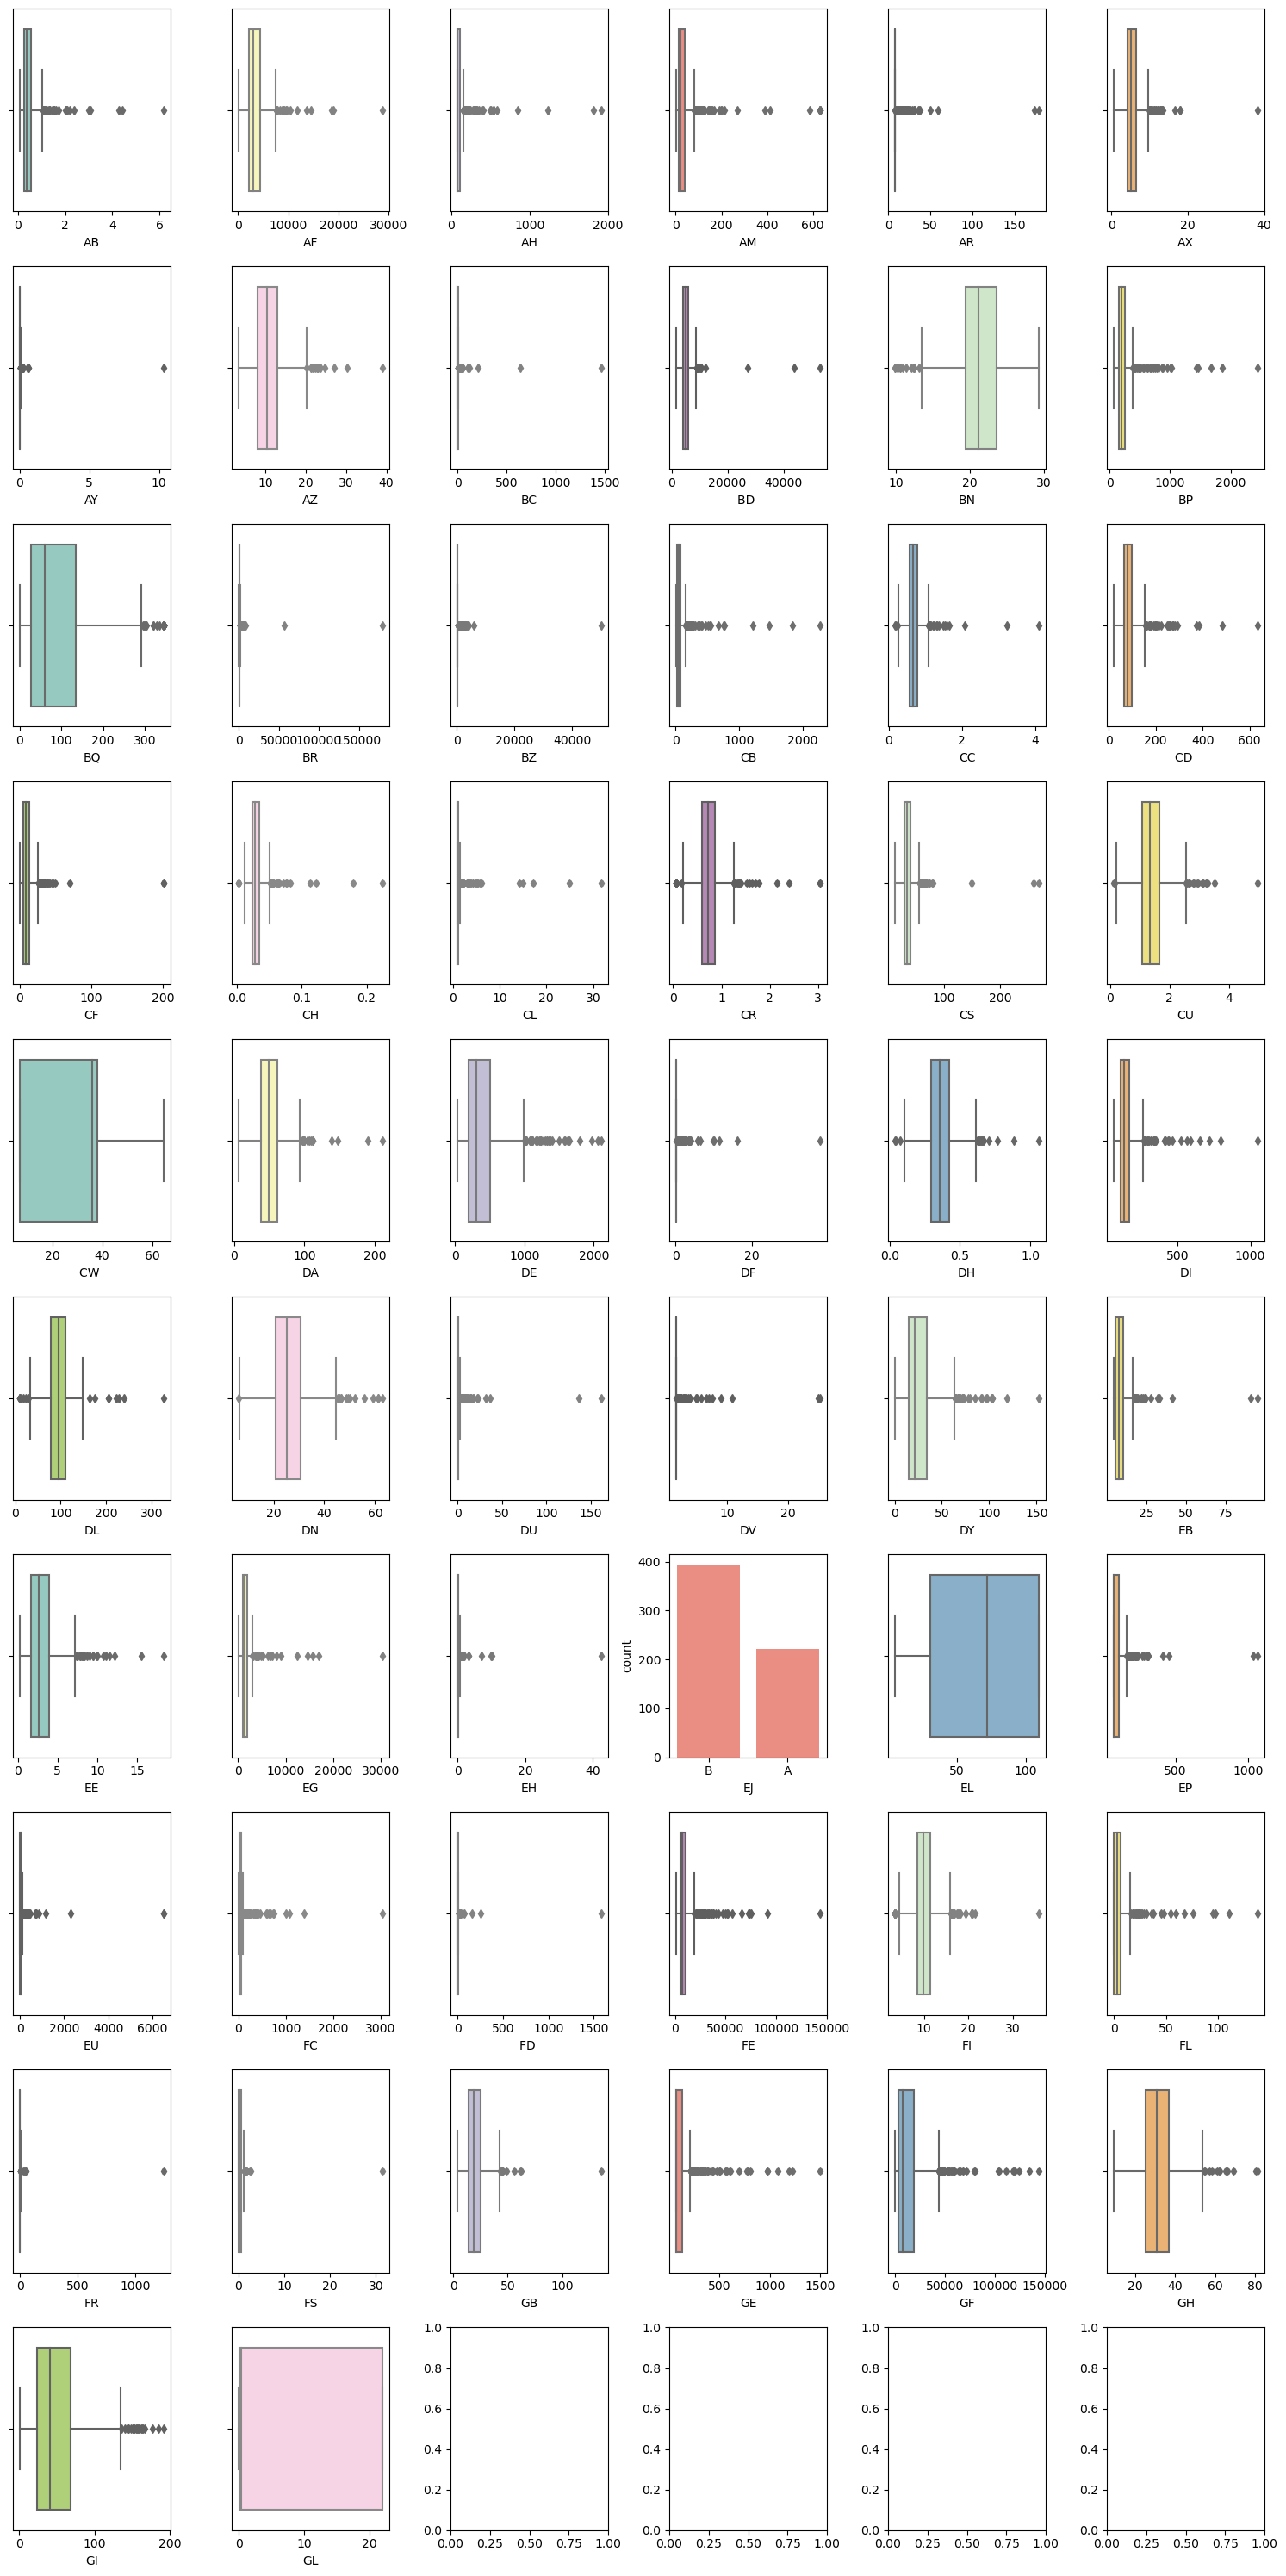

In [13]:
# boxplots Class 이용
    
boxplots(train)

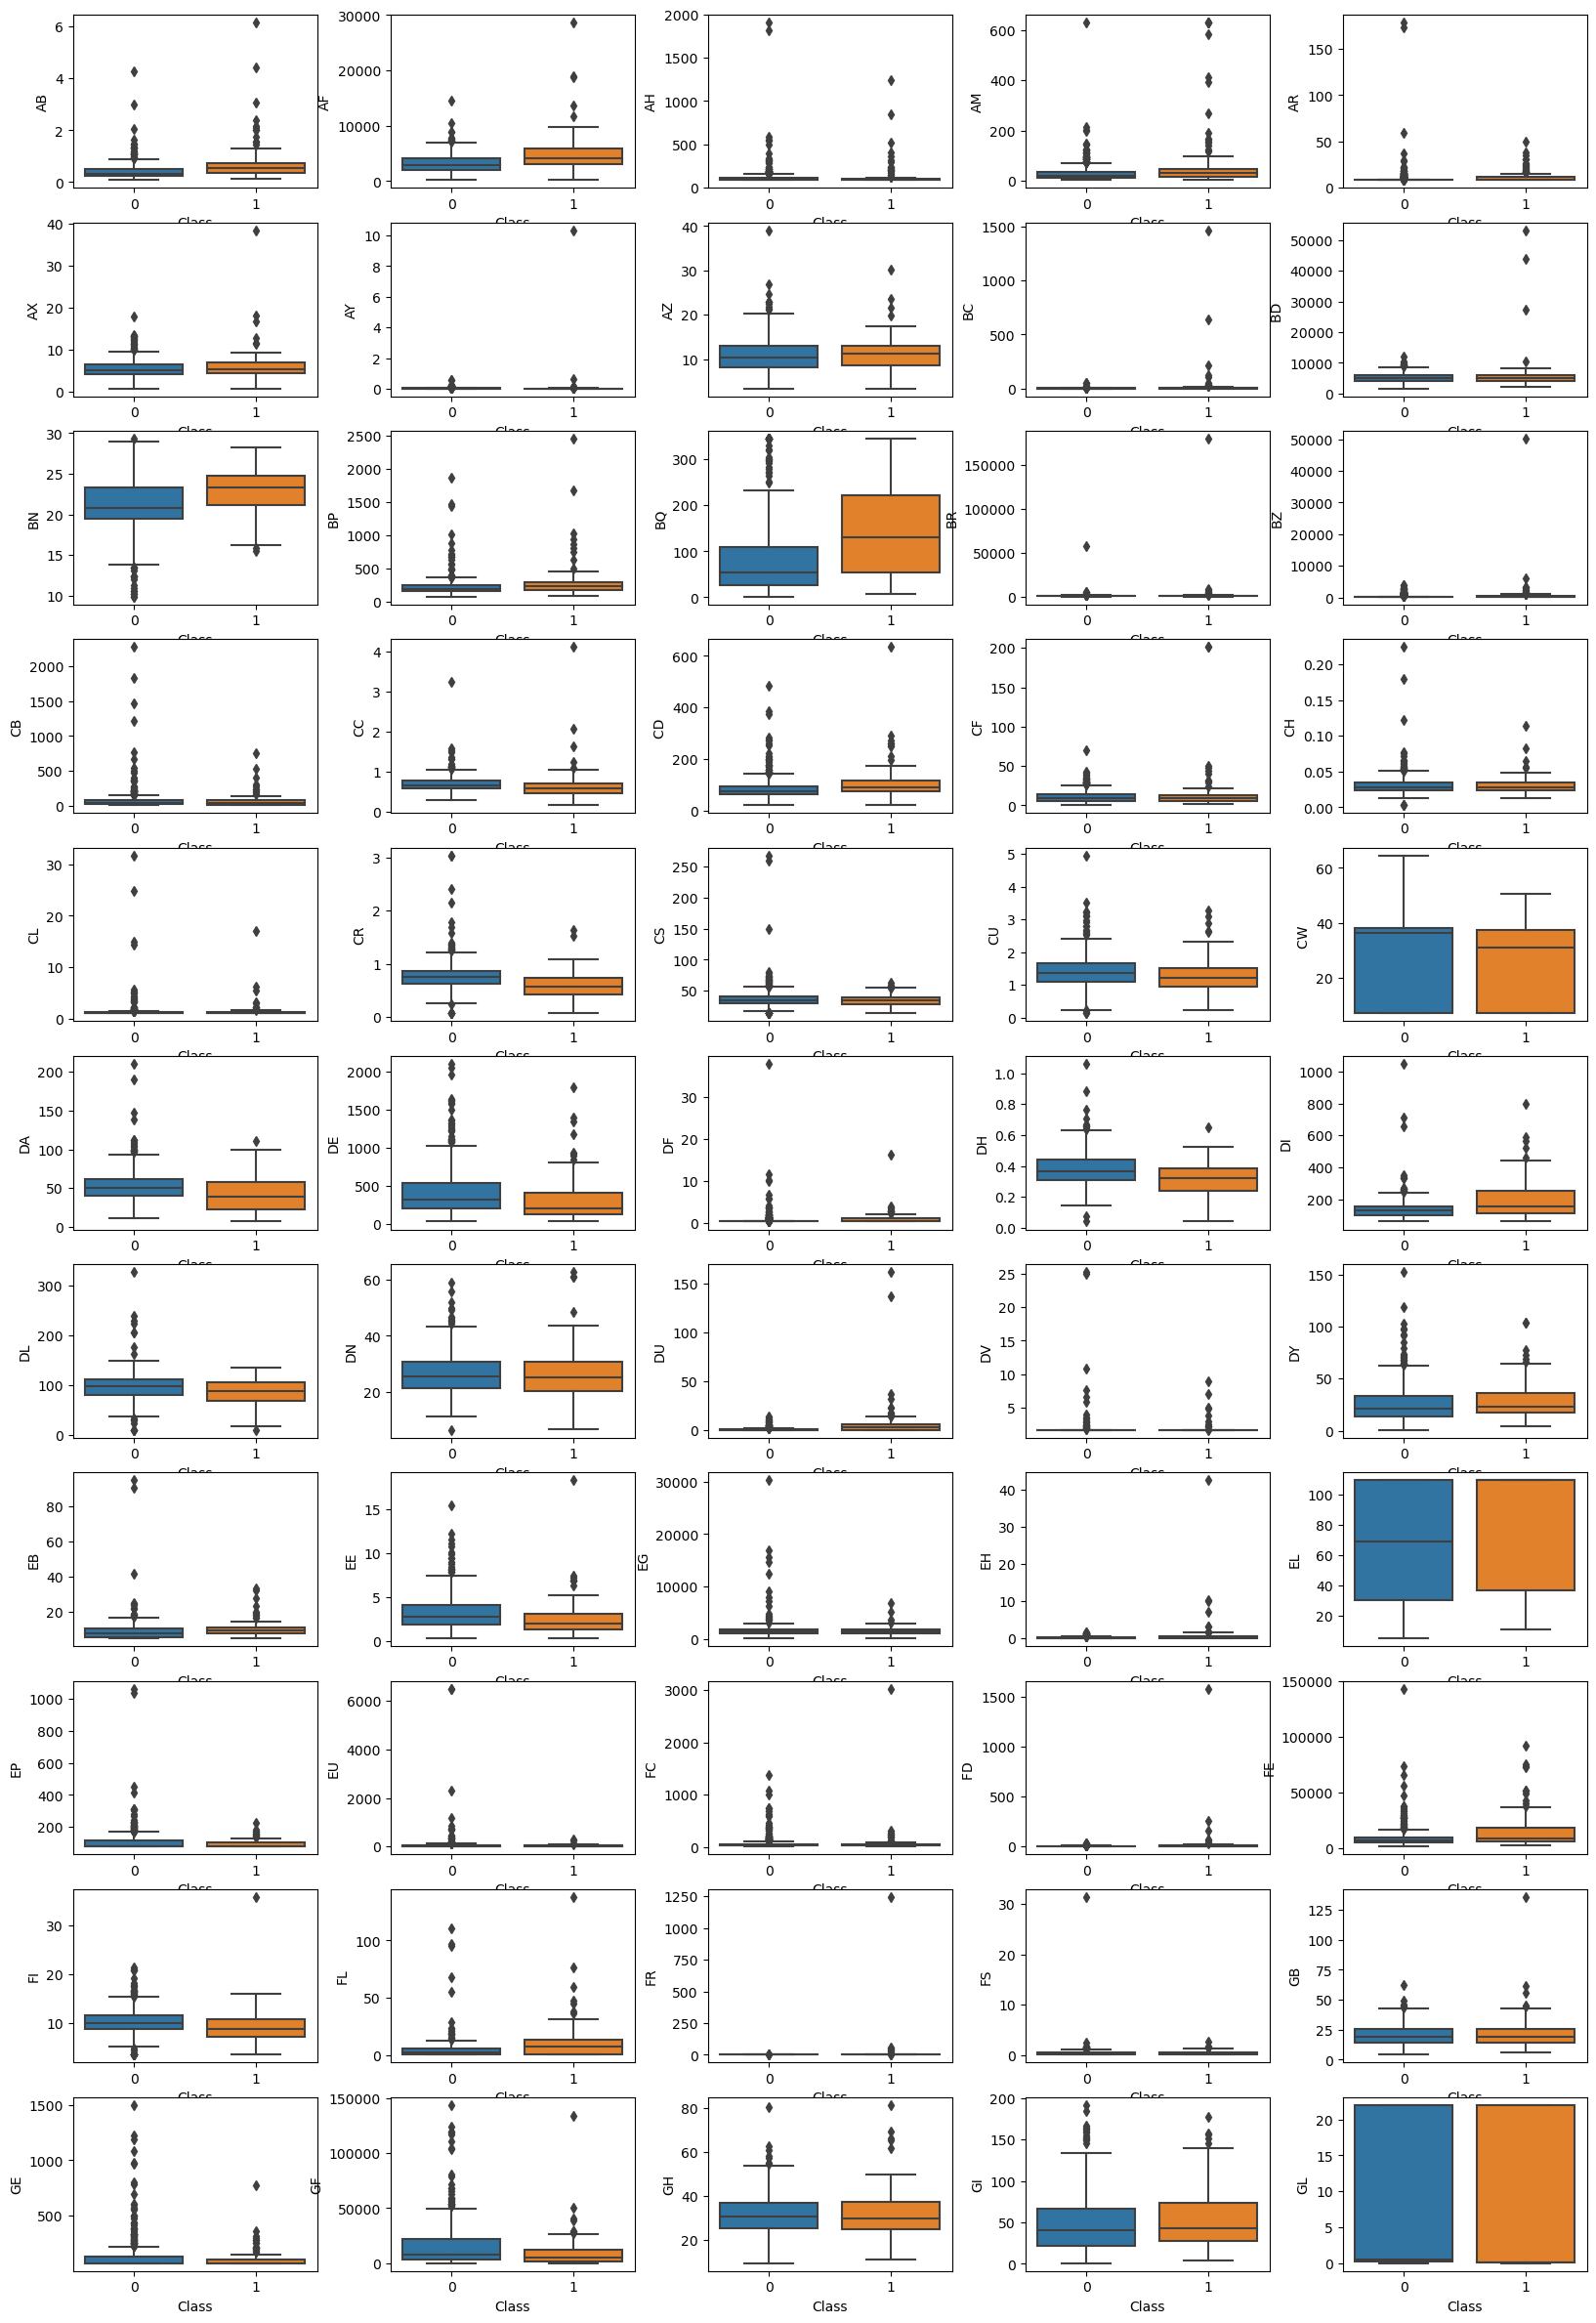

In [14]:
# Histgram for numercial features
fig, ax = plt.subplots(11, 5, figsize=(20,30))

for i in range(0, (len(ax.flatten()))):
    sns.boxplot(x="Class",y=train[num_features].columns[i],data=train, ax=ax[int(i/5),i % 5])

# Adjust the vertical spacing between subplots    
plt.subplots_adjust(wspace=0.3)  

plt.show()

### 추가적인 eda

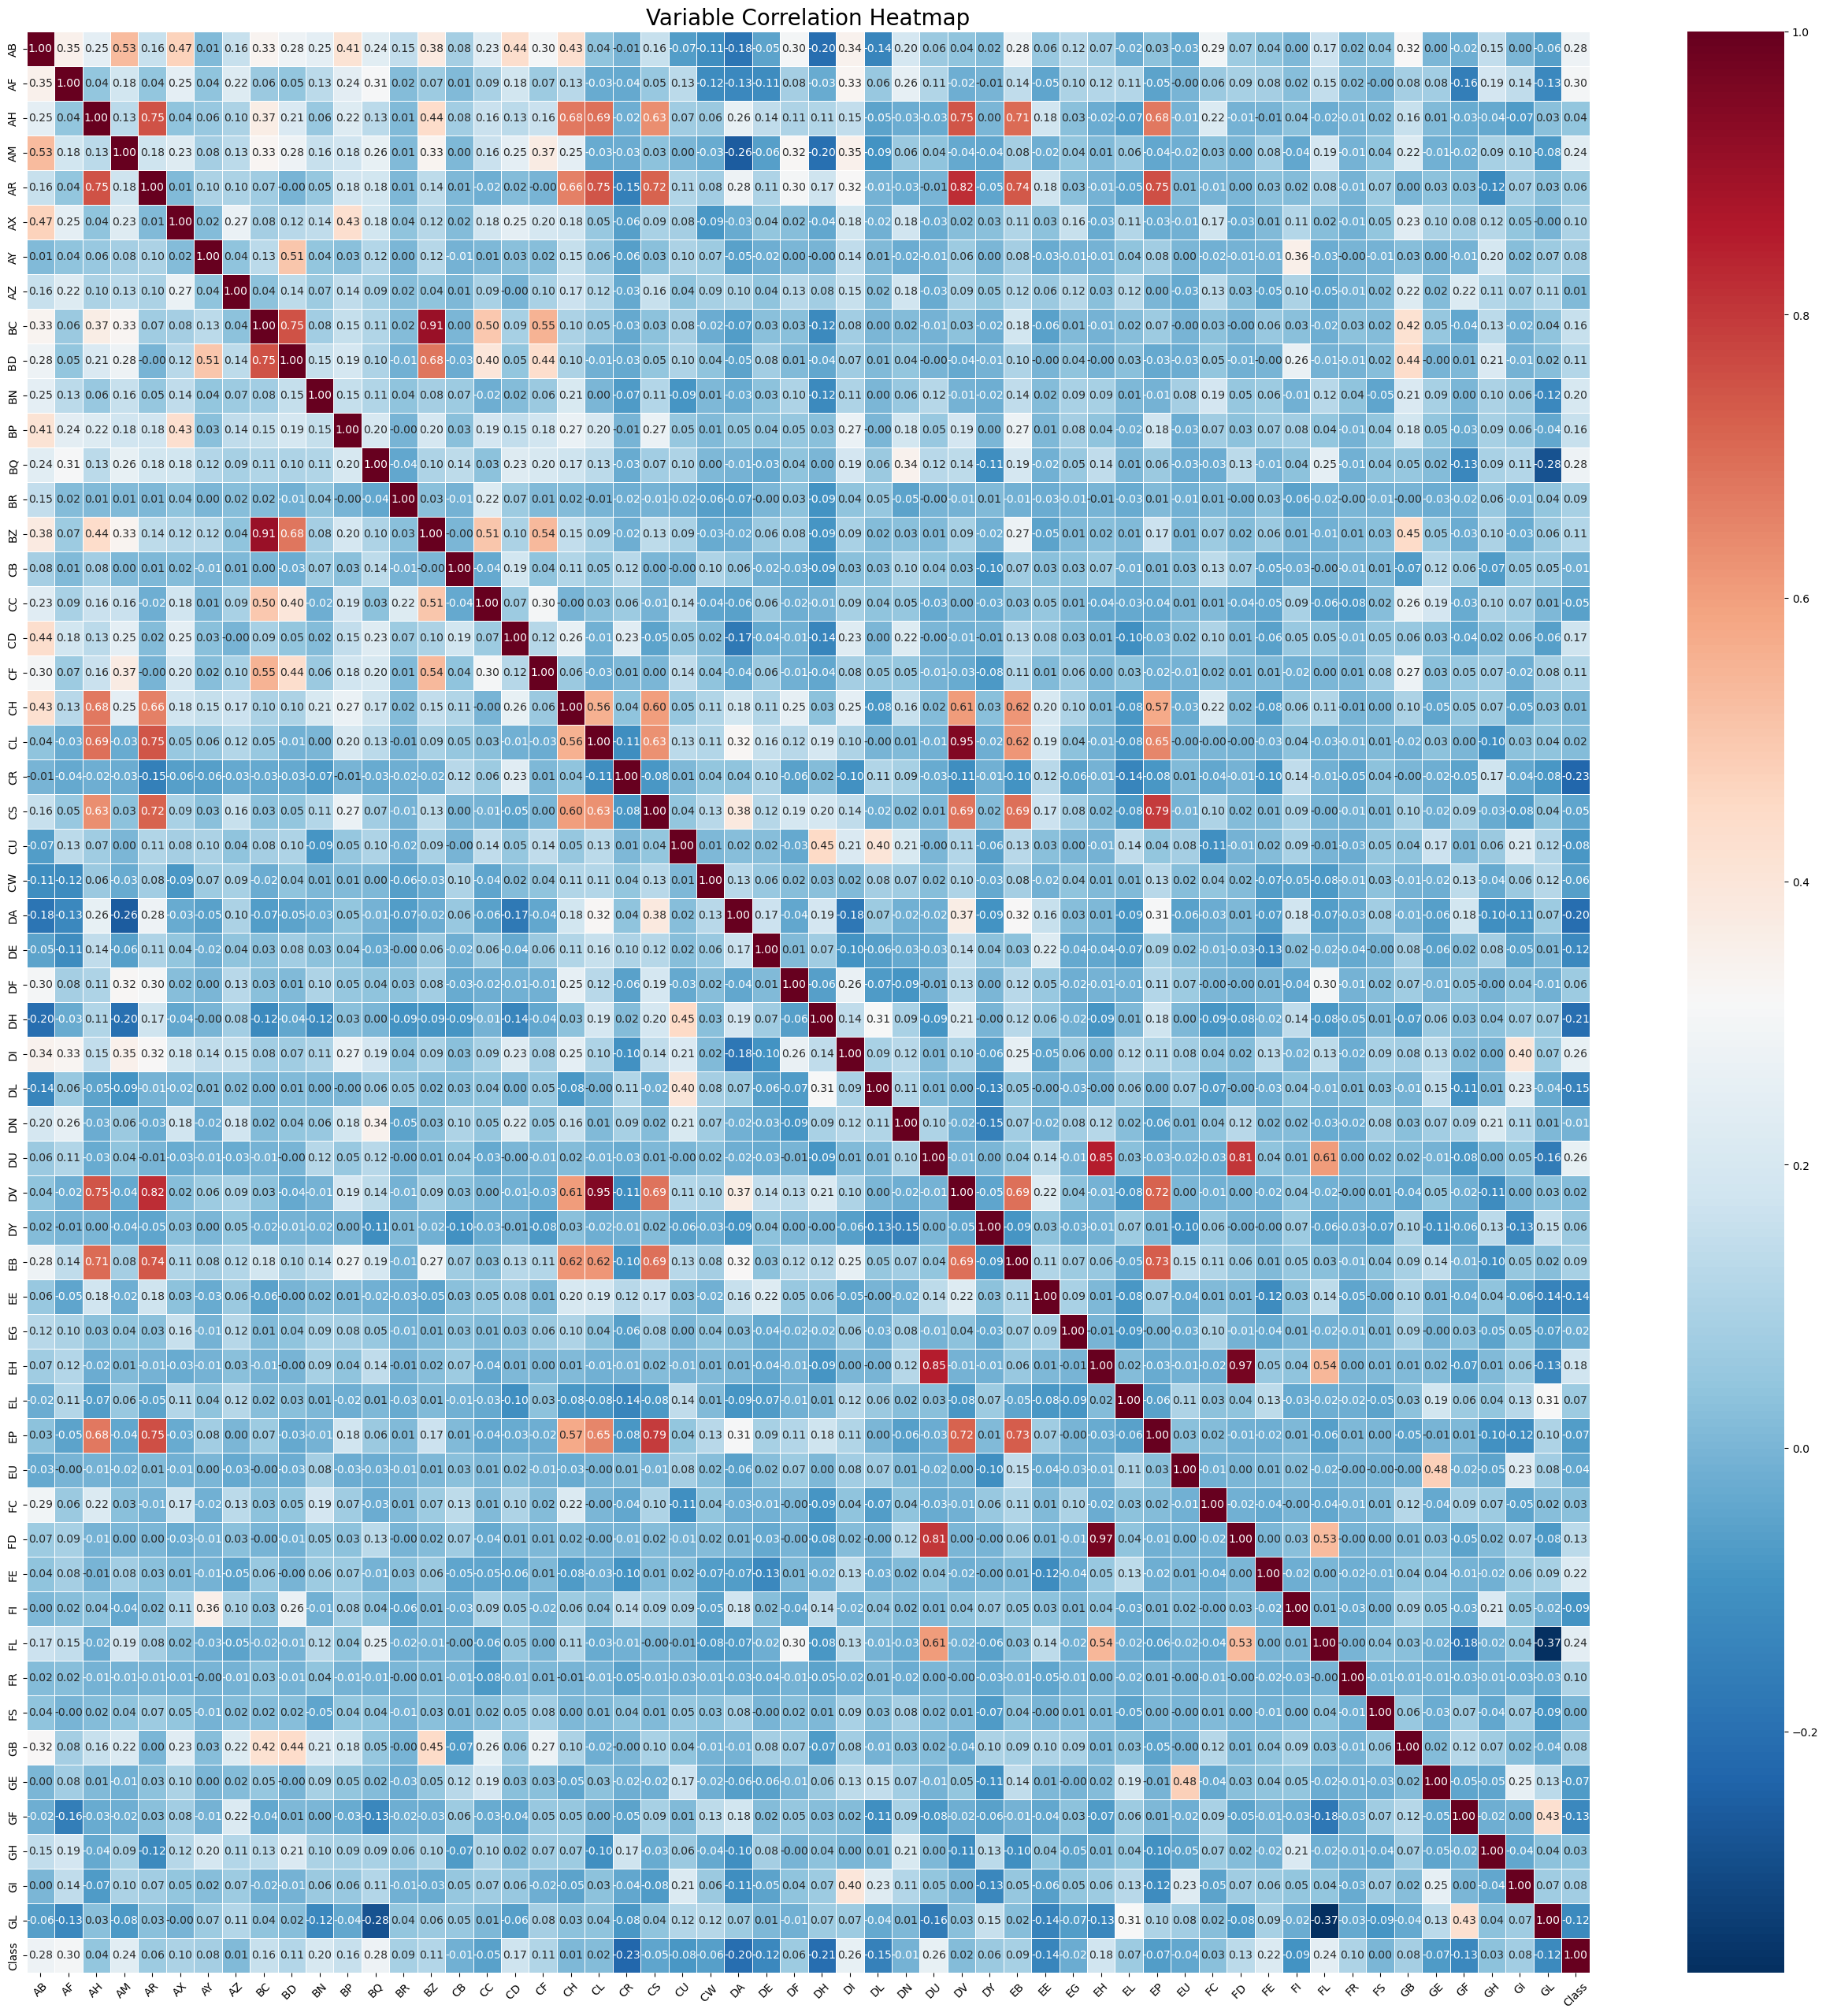

In [15]:
colormap = plt.cm.RdBu_r

correlation_matrix = train.corr()
fig, ax = plt.subplots(figsize=(32, 32))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, fmt=".2f", cmap=colormap, ax=ax)
ax.set_title("Variable Correlation Heatmap", fontsize=20)
plt.xticks(rotation=45)
plt.show()

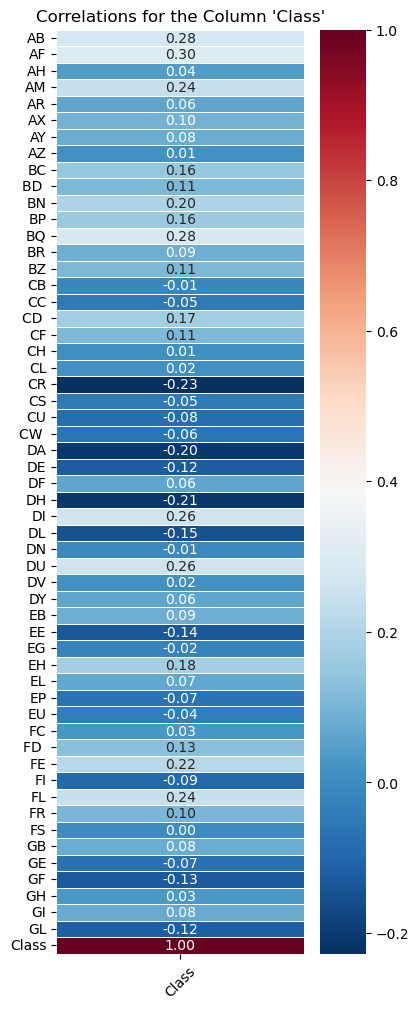

In [16]:
class_correlations = correlation_matrix['Class']

fig, ax = plt.subplots(figsize=(4, 12))
sns.heatmap(data=class_correlations.to_frame(), annot=True, linewidths=.5, fmt=".2f", cmap=colormap, ax=ax)
ax.set_title("Correlations for the Column 'Class'")
plt.xticks(rotation=45)
plt.show()

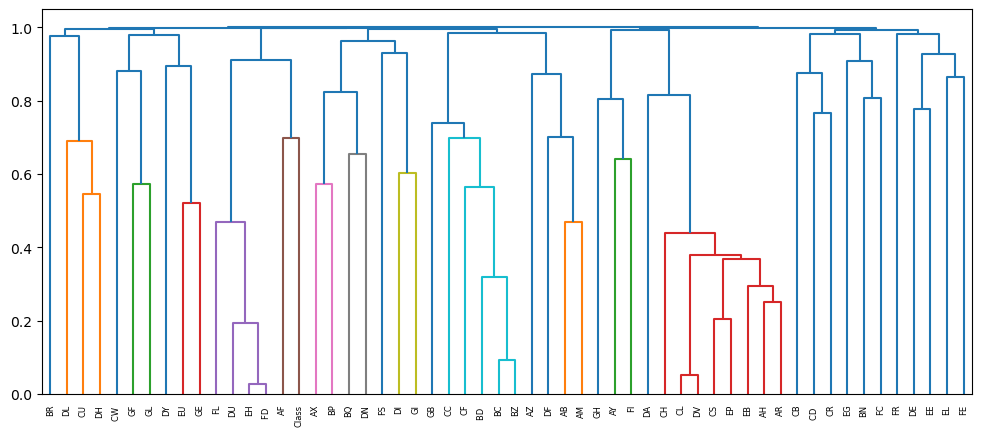

In [17]:
#Hierarchical Clustering

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(correlation_matrix)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=correlation_matrix.columns, orientation='top', 
           leaf_rotation=90);

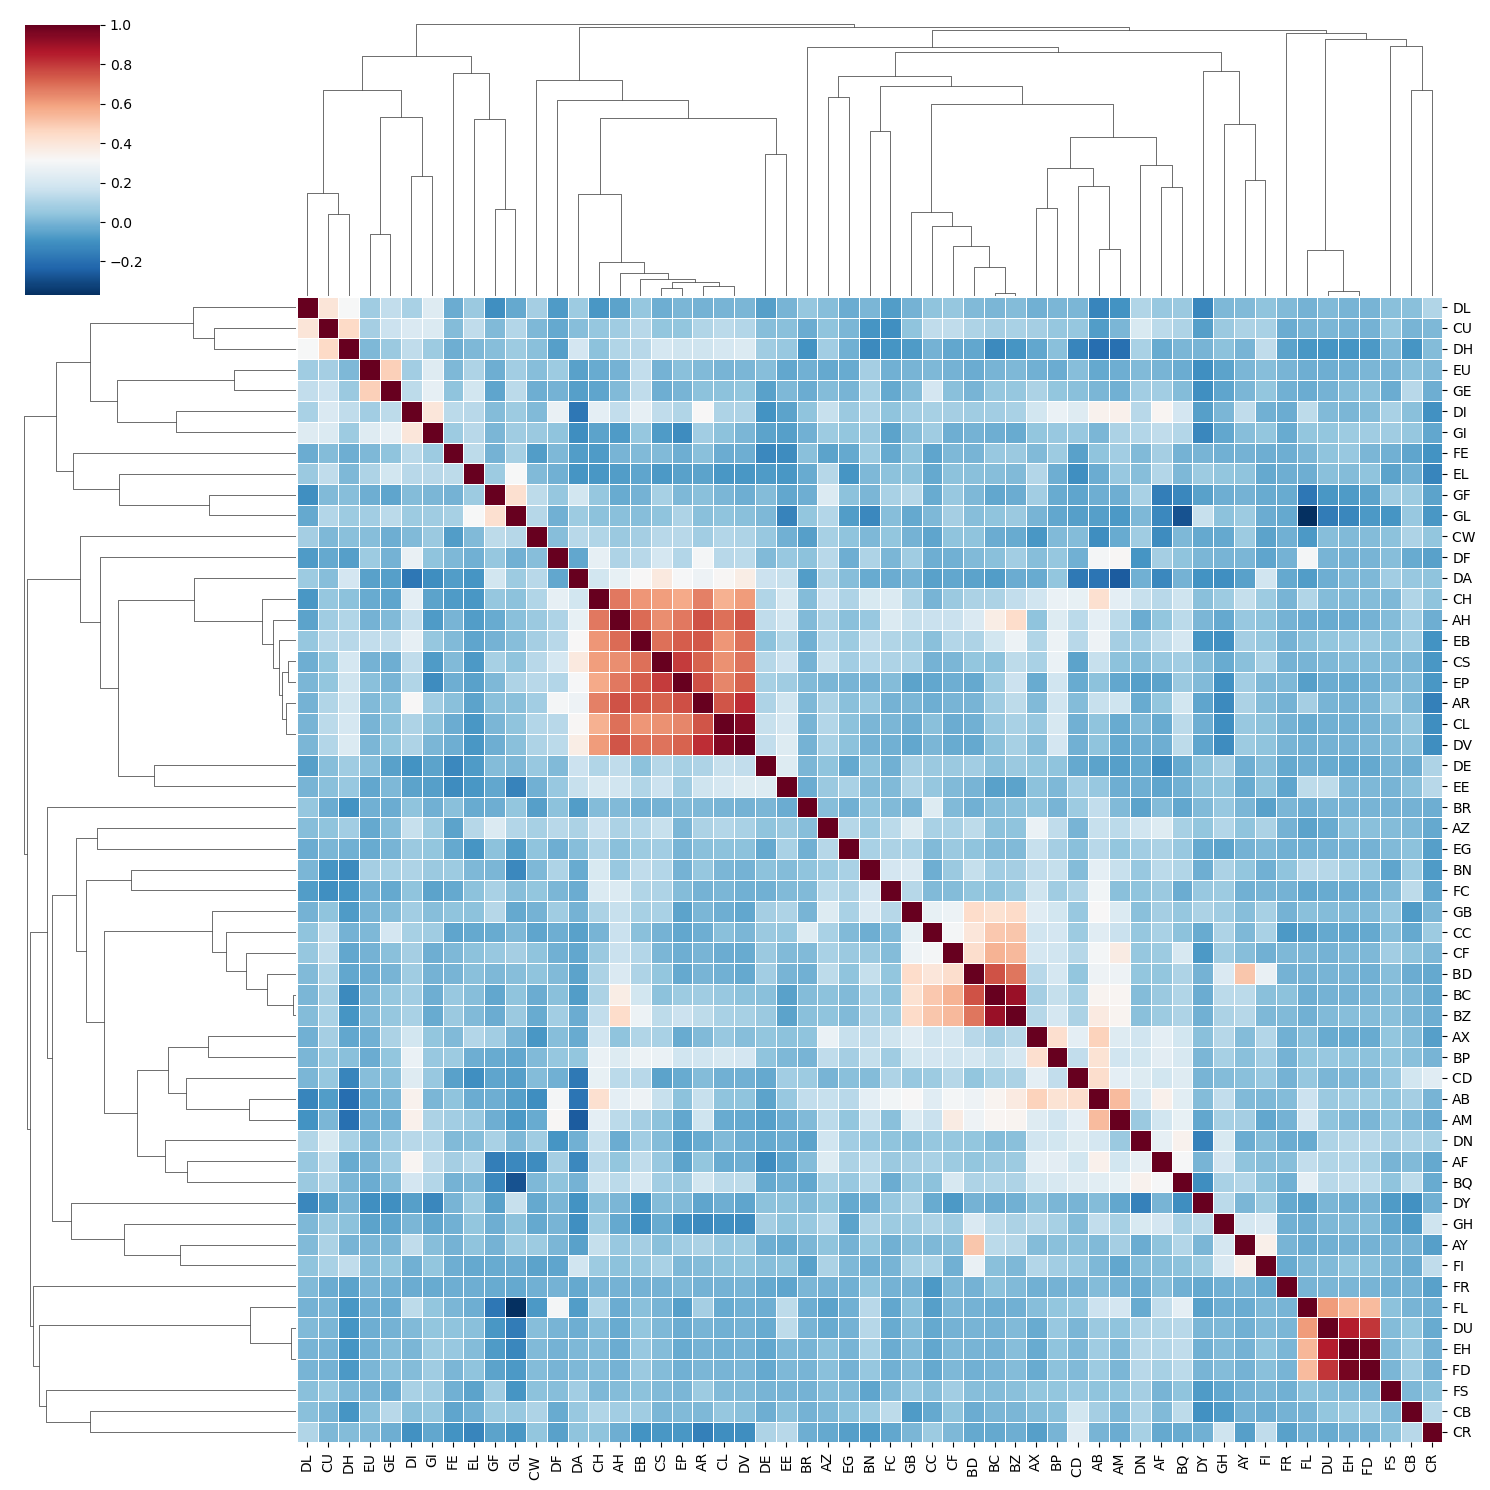

In [18]:
corr = train.loc[:, num_features].corr()
sns.clustermap(corr, metric="correlation", linewidths=.5, cmap=colormap, figsize=(15, 15))
plt.show()

Here we have several highly correlated features like BZ vs BC ( 0.91 ) or DV vs CL ( 0.95 )

As you can see, here we have minimal distances between BZ - BC, DV - CL, and EH - FD.

In [19]:
for df in [train, test]:
    df.rename({"BD ":"BD", "CD ":"CD", "CW ":"CW", "FD ":"FD"}, axis = 1, inplace = True)

In [20]:
temp = train.copy()
temp = pd.merge(greeks, temp, on='Id', how='inner')
display(temp.head())

,Id,Alpha,Beta,Gamma,Delta,Epsilon,AB,AF,AH,AM,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,B,C,G,D,3/19/2019,0.209377,3109.03329,85.200147,22.394407,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,A,C,M,B,Unknown,0.145282,978.76416,85.200147,36.968889,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,A,C,M,B,Unknown,0.470030,2635.10654,85.200147,32.360553,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,A,C,M,B,Unknown,0.252107,3819.65177,120.201618,77.112203,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,D,B,F,B,3/25/2020,0.380297,3733.04844,85.200147,14.103738,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


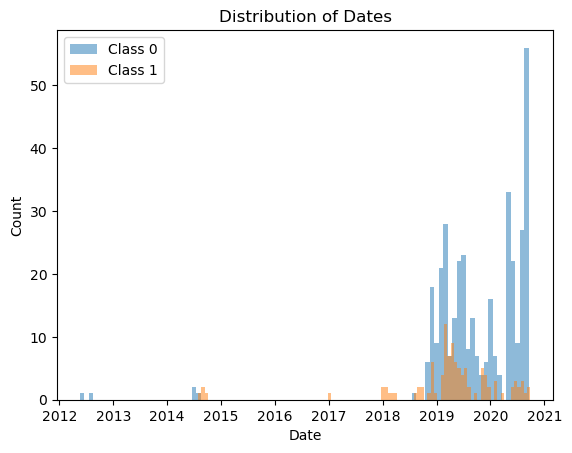

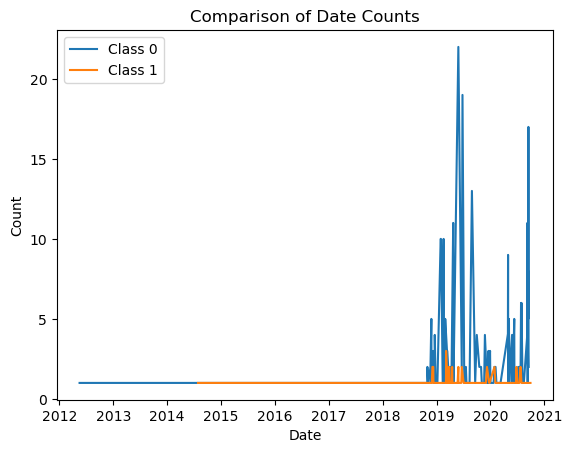

Correlation coefficient between Class and Numeric Date: -0.22824616381033103

Breakdown of Class for Unknown Epsilon 
 0    144
Name: Class, dtype: int64


In [21]:
# 1. Preprocess the data
temp2 = temp[temp['Epsilon'] != 'Unknown']
temp2['Epsilon'] = pd.to_datetime(temp2['Epsilon'], format='%m/%d/%Y')  
    # Convert date column to datetime format

# 2. Split the dataset
class_0 = temp2[temp2['Class'] == 0]
class_1 = temp2[temp2['Class'] == 1]

# 3. Extract date components
class_0['Month'] = class_0['Epsilon'].dt.month
class_0['Day'] = class_0['Epsilon'].dt.day
class_0['Year'] = class_0['Epsilon'].dt.year

class_1['Month'] = class_1['Epsilon'].dt.month
class_1['Day'] = class_1['Epsilon'].dt.day
class_1['Year'] = class_1['Epsilon'].dt.year

# 4. Analyze the data
# Example 1: Distribution analysis
plt.hist(class_0['Epsilon'], bins=100, alpha=0.5, label='Class 0')
plt.hist(class_1['Epsilon'], bins=100, alpha=0.5, label='Class 1')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Dates')
plt.legend()
plt.show()

# Example 2: Comparative analysis
class_0_date_counts = class_0['Epsilon'].value_counts().sort_index()
class_1_date_counts = class_1['Epsilon'].value_counts().sort_index()

plt.plot(class_0_date_counts.index, class_0_date_counts.values, label='Class 0')
plt.plot(class_1_date_counts.index, class_1_date_counts.values, label='Class 1')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Comparison of Date Counts')
plt.legend()
plt.show()

# 3. Print the correlation coefficient
temp2['Date'] = temp2['Epsilon'].dt.date
temp2['NumericDate'] = (temp2['Date'] - temp2['Date'].min()).dt.days
correlation = temp2['Class'].corr(temp2['NumericDate'])
print("Correlation coefficient between Class and Numeric Date:", correlation)

# 4. Print info of unknowns
temp3 = temp[temp['Epsilon'] == 'Unknown']

print("\nBreakdown of Class for Unknown Epsilon \n", temp3.Class.value_counts())

In [22]:
# # if want to use greeks data ## greeks
# num_features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ',
#                       'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ',
#                       'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW',
#                       'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
#                       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU',
#                       'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS',
#                       'GB', 'GE', 'GF', 'GH', 'GI', 'GL']

# cat_features = ['EJ', 'Alpha', 'Beta', 'Gamma', 'Delta'] 
# date_features = ['Epsilon']
# features = num_features + cat_features + date_features

In [23]:
# greeks.Gamma.value_counts()

In [24]:
# mask = greeks["Gamma"] == "M"
# greeks.loc[mask,:]

In [25]:
# #B,D,G 1 // A:0
# doc = {'A':'G','B':'G','E':'D','F':'D','G':'B','H':'B','M':'A','N':'A'}
# greeks.Gamma.map(doc).equals(greeks.Alpha)

In [26]:
# train = temp.drop('Epsilon', axis=1)
# display(train.head())

In [27]:
# print(greeks.Gamma.value_counts())
# print(greeks)
# print(greeks.Alpha.value_counts())

In [28]:
#train.Class.value_counts() # class imbalance 가 존재

## "Alpha" == "Gamma" 같은 분류로 된다.
## "BN" == age로 추정
## categorical feature -> EJ 
## 결측치들이 좀 있다. -> KNNImputer
## class imbalance가 있다. -> sampling (undersampling vs oversampling)

# undersampling : majority class에서 데이터를 sampling 해서 1:1 비율을 맞춰주는 기법.
#                e.g. class0 : 1000, class1 : 100 : --------> class0:100 , class1 : 100

# oversampling : miniority class에서 데이터를 생성 (oversampling)하여 1:1로 크기를 맞춰주는 기법.
#                e.g. class0 : 1000, class1 : 100 : ---------> class0 : 1000, class1 : 1000

# 3. Data Preprocessing

LabelEncoding -> KNN Imputation -> (optional)calculate VIF -> (optional)apply PCA -> feature Scaling


                           -> (optional)feature selection  ------->

In [29]:
lb = LabelEncoder()
train.EJ = lb.fit_transform(train.EJ)  # A->0, B->1
train = train.drop(columns=["Id"])

In [30]:
imp = KNNImputer()
labels = train["Class"]
train = train.drop(columns="Class")
data = imp.fit_transform(train)
tmp = pd.DataFrame(columns=train.columns, data=data)
train = pd.concat([tmp, labels], axis=1)
train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


In [31]:
# check missing data
train[train.isnull().any(axis=1)]

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class


In [32]:
def check_vif(df):
    vifs = [variance_inflation_factor(df, i) for i in range(df.shape[1])]
    vif_df = pd.DataFrame({"features":df.columns, "VIF" : vifs})
    vif_df = vif_df.sort_values(by="VIF", ascending=False)
    remove_col = vif_df.iloc[0, 0]
    top_vif = vif_df.iloc[0, 1]
    return vif_df, remove_col, top_vif

In [33]:
# remove all features when VIF is over 10.
if apply_vif:
    top_vif = 100

    while(top_vif > 5):
        vif_df, remove_col, top_vif = check_vif(train)
        print(remove_col, top_vif)
        if top_vif < 5:
            break
        train = train.drop(columns=remove_col)

    display(train)

In [34]:
# feature selection via Feature Importance base line
X = train.drop(columns=["Class"])
y = train['Class']

In [35]:
# feature selection via Feature Importance

if feature_selection:
    rf_param_grid = {'n_estimators': 100, 'max_depth': 10, 'max_features': 0.7}
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf.fit(X, y)
    print("Train ACC : %.4f" % accuracy_score(y, rf.predict(X)))
    fi_df = pd.DataFrame({'feature':X.columns, 'importance':rf.feature_importances_})
    selected_cols = fi_df.sort_values(by="importance", ascending=False)[:m]["feature"].values
    
    display(selected_cols)
    
    X = train[selected_cols]
    display(X)

In [36]:
## 2) feature selected by EDA. #36개 8x5의 모양 요구 

if feature_selection_2_1:
    features = ['AB', 'AF', 'AH', 'AX', 'AZ', 'BC', 'BN', 'BP', 'BQ', 'CB', 'CC', 'CD', 'CH', 'CL', 'CR', 'DA', 
                'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EP', 'FD', 
                'FE', 'FI', 'FL', 'FR', 'GE', 'GF', 'GH', 'GL','Id']

    drop_features = [f for f in test.columns if f not in features]
    print(f"Dropped features : {drop_features}")


    #Drop out low informative features for model training 
    X = train.drop(drop_features + ['Class'], axis=1)
    selected_cols = ['AB', 'AF', 'AH', 'AX', 'AZ', 'BC', 'BN', 'BP', 'BQ', 'CB', 'CC', 'CD', 'CH', 'CL', 'CR', 'DA', 
                'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EP', 'FD', 
                'FE', 'FI', 'FL', 'FR', 'GE', 'GF', 'GH', 'GL']

    print(selected_cols)
    print(X.shape, y.shape)


Dropped features : ['AM', 'AR', 'AY', 'BD', 'BR', 'BZ', 'CF', 'CS', 'CU', 'CW', 'EL', 'EU', 'FC', 'FS', 'GB', 'GI']
['AB', 'AF', 'AH', 'AX', 'AZ', 'BC', 'BN', 'BP', 'BQ', 'CB', 'CC', 'CD', 'CH', 'CL', 'CR', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EP', 'FD', 'FE', 'FI', 'FL', 'FR', 'GE', 'GF', 'GH', 'GL']
(617, 40) (617,)


In [37]:
## 2)-2 feature selected by EDA. with Brute Force Features. (추가 데이터 생성) #45개 9x5의 모양 요구 #----> 수정요

if feature_selection_2_2:
    features = ['AB', 'AF', 'AM', 'AY', 'AZ', 'BC', 'BN', 'BP', 'BQ', 'BR', 'CC', 'CD', 'CF', 
                'CH', 'CL', 'CR', 'CS', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 
                'DY', 'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI', 'FL', 
                'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI','GL', 'Id'] 

    drop_features = [f for f in test.columns if f not in features]
    print(f"Dropped features : {drop_features}")


    #Drop out low informative features for model training 
    X = train.drop(drop_features + ['Class'], axis=1)
    selected_cols = ['AB', 'AF', 'AM', 'AY', 'AZ', 'BC', 'BN', 'BP', 'BQ', 'BR', 'CC', 'CD', 'CF', 
                'CH', 'CL', 'CR', 'CS', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 
                'DY', 'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI', 'FL', 
                'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI','GL'] 

    print(selected_cols)
    print(X.shape, y.shape)

In [38]:
## 3) feature selection by auto-selection.
# auto-selection.

if feature_selection_3:
    threshold = 0.1
    t_score = 10

    fs = SelectKBest(score_func=f_classif, k=len(X.columns))


    # apply feature selection
    X_selected = fs.fit_transform(X, y.values)
    print('Befoe the SelectKBest = {}'.format(X.shape))

    new_features = [] # The list of features less than the p-values
    drop_features = [] # The list of features higher than the p-values

    for i in range(len(X.columns)):
        print('Feature {}: {:.3f} with p-value {:.3f}'.format(X.columns[i], fs.scores_[i], fs.pvalues_[i]))
        if fs.pvalues_[i] <= threshold and fs.scores_[i] >= t_score:
            new_features.append(X.columns[i])
        else:
            drop_features.append(X.columns[i])


    selected_cols =  pd.DataFrame(X_selected)
    selected_cols.columns = X.columns
    selected_cols = selected_cols[new_features]

    print(selected_cols)
    print('=' * 30)
    print('After the SelectKBest = {}'.format(selected_cols.shape))
    print('Drop-out Features = {}'.format(len(drop_features)))
    print("\n")

    #Drop out low informative features for model training 
    X = train.drop(drop_features + ['Class'], axis=1)
    selected_cols = selected_cols.columns
    print(selected_cols)
    print(X.shape, y.shape)

    train.shape

In [39]:
# class imbalance handling
## 1. undersampling
if sampling_method == 'under':
    c1 = train[train.Class == 1]
    c0 = train[train.Class == 0]
    print(c1.shape, c0.shape) # 108, 509 -> 108, 108
    c0 = c0.sample(n=c1.shape[0]) # 509 -> 108
    train = pd.concat([c0, c1])
    print(train.shape)
    X = train[selected_cols]
    y = train['Class']
    print(X.shape, y.shape)

In [40]:
## 2. oversampling -> SMOTE
if sampling_method == 'over':
    X = train[selected_cols]
    y = train['Class']

    smote = SMOTE(k_neighbors=5)
    # fit_resample 함수가 자동으로 minority class를 y 기준으로 찾아서, 1:1로 맞춰줌.
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(X_resampled.shape, y_resampled.shape)
    X_resampled["Class"] = y_resampled
    train = X_resampled

In [41]:
# 3. hybrid approach
## class0 : 509 -> 300
## class1 : 108 -> 300
if sampling_method == 'hybrid':
    N = 500
    c1 = train[train.Class == 1]
    c0 = train[train.Class == 0]
    print(c1.shape, c0.shape)
    c0 = c0.sample(n=N) # 509 -> 300
    train = pd.concat([c0, c1])
    print(train.shape)
    
    if feature_selection or feature_selection_2_1 or feature_selection_2_2 or feature_selection_3:
        X = train[selected_cols]
    else:
        X = train.drop("Class", axis=1)
    y = train.Class

    smote = SMOTE(k_neighbors=5)
    # The fit_resample function automatically finds the minority class by y and fits it 1:1.
    X, y = smote.fit_resample(X, y) # 300, 108 --> 300, 300
    print(X.shape, y.shape)
    display(X), display(y)

(108, 57) (509, 57)
(608, 57)
(1000, 40) (1000,)


,AB,AF,AH,AX,AZ,BC,BN,BP,BQ,CB,...,EP,FD,FE,FI,FL,FR,GE,GF,GH,GL
0,0.376024,3331.381680,103.079724,5.678619,14.223614,3.092320,16.948800,190.377729,45.017005,41.598466,...,182.585397,4.636797,12578.179320,13.363512,0.794236,0.497060,72.611063,1171.855836,35.301127,9.801000
1,0.452938,4570.765320,85.200147,4.296615,12.118746,7.042056,17.301900,197.516205,10.917555,101.404303,...,111.237269,6.328842,9247.148874,11.571787,4.272654,1.598480,110.058389,18417.619300,26.646081,0.242104
2,0.162374,192.593280,85.200147,4.890168,3.396778,2.168138,25.070100,242.369064,78.999230,72.719192,...,97.310597,3.686877,2564.145893,16.395662,2.456055,1.931980,72.611063,904.153914,30.720576,3.564000
3,0.632404,3093.425500,85.200147,4.695270,3.396778,1.229900,21.539100,272.122605,72.043880,109.382091,...,78.526968,2.451981,9687.460422,7.486654,1.633415,1.162900,118.061993,6016.454496,41.396125,3.564000
4,0.329021,5266.084560,143.480775,5.076207,15.294954,1.229900,25.070100,220.385610,30.169808,23.960937,...,92.690000,0.296850,6472.462974,8.983434,0.173229,1.099100,138.190262,5732.603766,28.454487,21.978000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.445656,4140.532237,85.200147,4.871080,6.659088,3.218722,23.487379,288.515382,104.482944,38.863153,...,95.770533,86.502306,8671.499331,7.845916,43.658520,1.785353,72.611063,10388.158946,27.464925,0.023727
996,0.514459,4328.609747,85.200147,7.263525,5.877416,2.677474,23.657700,187.892334,273.168890,25.483064,...,110.187149,0.296850,7226.671348,8.326746,0.173229,0.497060,72.611063,14605.232231,23.714934,21.978000
997,4.367081,15935.946594,137.839426,29.752043,17.428571,15.345648,20.706028,1851.365050,344.644105,251.776606,...,105.447719,3.014144,11012.460300,12.700950,4.127548,25.171954,270.321526,11021.590508,60.937602,9.345340
998,0.744134,6889.445657,86.292503,4.133269,4.540077,11.088669,26.187276,278.753595,112.281132,32.315018,...,78.526968,8.797546,3187.237120,10.207831,19.790442,3.517337,72.611063,1208.856737,26.910872,2.054182


0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    1
997    1
998    1
999    1
Name: Class, Length: 1000, dtype: int64

### Checking for Outliers

In [42]:
## outliner omit
if outliner:
    temp_df = X.copy()


    for col in temp_df.columns:
        if col != 'EJ' and 'Class':
            ZRscore_outlier(temp_df[col])  

    for col in temp_df.columns:
        if col != 'EJ' and 'Class':
            outliers = [x for x in temp_df[col] if x in out]
            mean = np.mean([x for x in temp_df[col] if x not in out])
            temp_df[col] = [mean if x in outliers else x for x in temp_df[col]]
        

# # Histgram for numercial features
# if outliner:
#     if feature_selection:
#         fig, ax = plt.subplots(4, 5, figsize=(20,30)) #1 # 4, 5를 feature importance의 수만큼 맞춰줘야한다!!! -> [중요]
#     if feature_selection_2_1:
#         fig, ax = plt.subplots(8, 5, figsize=(20,30)) #2-1 # 8, 5
#     if feature_selection_2_2:
#         fig, ax = plt.subplots(6, 8, figsize=(20,30)) #2-2 # 11,5
#     if feature_selection_3:
#         fig, ax = plt.subplots(4, 5, figsize=(20,30)) #2 # 4,5 
    
    temp_df = pd.concat([X,y],axis=1) # 얘는 항상 있어야함.
        
#     for i in range(0, (len(ax.flatten()))):
#         if feature_selection_2_2:
#             sns.boxplot(x="Class",y=temp_df.columns[i],data=temp_df, ax=ax[int(i/8),i % 8])
#         else:
#             sns.boxplot(x="Class",y=temp_df.columns[i],data=temp_df, ax=ax[int(i/5),i % 5])
        
            

#     # Adjust the vertical spacing between subplots    
#     plt.subplots_adjust(wspace=0.3)  

#     plt.show()

    ## split
    X = temp_df.drop(columns=["Class"])
    y = temp_df['Class']

In [43]:
y.value_counts()

0    500
1    500
Name: Class, dtype: int64

### feature scaling

- Use StandardScaler

In [44]:
if is_scaling:
    scaler = StandardScaler()
    data_ = scaler.fit_transform(X)
    X = pd.DataFrame(data=data_, columns=X.columns)
    display(X)

,AB,AF,AH,AX,AZ,BC,BN,BP,BQ,CB,...,EP,FD,FE,FI,FL,FR,GE,GF,GH,GL
0,-0.355714,-0.235322,-0.173114,0.008208,0.872144,-0.153305,-1.591259,-0.306770,-0.754623,-0.224829,...,1.459114,-0.096197,0.048836,1.156404,-0.529695,-0.105659,-0.397167,-0.648415,0.399795,0.229188
1,-0.212124,0.263745,-0.309669,-0.500402,0.375376,-0.119163,-1.479447,-0.270569,-1.117849,0.234778,...,0.174090,-0.078494,-0.207818,0.567759,-0.271051,-0.092003,-0.094728,0.336498,-0.489600,-0.775998
2,-0.754576,-1.499229,-0.309669,-0.281961,-1.683089,-0.161293,0.980416,-0.043103,-0.392645,0.014333,...,-0.076738,-0.106136,-0.722739,2.152572,-0.406128,-0.087867,-0.397167,-0.663703,-0.070904,-0.426677
3,0.122919,-0.331140,-0.309669,-0.353688,-1.683089,-0.169404,-0.137704,0.107788,-0.466733,0.296087,...,-0.415043,-0.119057,-0.173892,-0.774351,-0.467297,-0.097403,-0.030087,-0.371738,1.026119,-0.426677
4,-0.443464,0.543732,0.135448,-0.213494,1.124991,-0.169404,0.980416,-0.154590,-0.912774,-0.360373,...,-0.159958,-0.141605,-0.421606,-0.282606,-0.575872,-0.098194,0.132477,-0.387949,-0.303768,1.509687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.225719,0.090502,-0.309669,-0.288986,-0.913154,-0.152212,0.479235,0.190921,-0.121193,-0.245850,...,-0.104476,0.760348,-0.252172,-0.656321,2.657564,-0.089685,-0.397167,-0.122068,-0.405456,-0.798962
996,-0.097271,0.166236,-0.309669,0.591492,-1.097635,-0.156891,0.533168,-0.319375,1.675644,-0.348675,...,0.155176,-0.141605,-0.363495,-0.498351,-0.575872,-0.105659,-0.397167,0.118771,-0.790806,1.509687
997,7.095155,4.840205,0.092362,8.867807,1.628544,-0.047385,-0.401503,8.116702,2.436995,1.390386,...,0.069816,-0.113175,-0.071802,0.938729,-0.281840,0.200290,1.199622,-0.085892,3.034208,0.181272
998,0.331508,1.197417,-0.301326,-0.560517,-1.413260,-0.084183,1.334178,0.141416,-0.038127,-0.296172,...,-0.415043,-0.052664,-0.674731,0.119651,0.882805,-0.068210,-0.397167,-0.646302,-0.462390,-0.585445


In [45]:
if is_pca:
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=0.90, random_state=42)
    data_ = pca.fit_transform(X)
    X = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])
    display(X)

# 3. Setting Evaluation metric


- does not need anymore.

In [46]:
# set metric
evaluation_metric = balance_logloss

# 4. (Super)Hyper-parameter Tuning and OOF prediction

Let's try hyper-parameter tuning using optuna, an AutoML framework.

Optuna defines a target function to optimize and then optimizes that function.

For each model, we define an optimizer function separately and then burn optuna.

In [47]:
# # apply same preprocessing in Testset 디버깅용
# X_train_ = pd.read_csv('../input/icr-identify-age-related-conditions/train.csv')
# X_train_.rename({"BD ":"BD", "CD ":"CD", "CW ":"CW", "FD ":"FD"}, axis = 1, inplace = True)
# test = X_train_.drop("Class", axis=1)

# train = train.drop("Class", axis=1)

# test.EJ = lb.transform(test.EJ)  # A->0, B->1
# test = test.drop(columns=["Id"])
# X_test = pd.DataFrame(columns=test.columns, data=imp.transform(test))

# if apply_vif:
#     X_test = X_test[train.columns]
    
# if feature_selection or feature_selection_2_1 or feature_selection_2_2 or feature_selection_3:
#     X_test = X_test[selected_cols]

# if is_scaling:
#     X_test = pd.DataFrame(columns=X_test.columns, data=scaler.transform(X_test))

# if is_pca:
#     data_ = pca.transform(X_test)
#     X_test = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])

# X_test

In [48]:
# apply same preprocessing in Testset
train = train.drop("Class", axis=1)
test.EJ = lb.transform(test.EJ)  # A->0, B->1
test = test.drop(columns=["Id"])
X_test = pd.DataFrame(columns=test.columns, data=imp.transform(test))

if apply_vif:
    X_test = X_test[train.columns]
    
if feature_selection or feature_selection_2_1 or feature_selection_2_2 or feature_selection_3:
    X_test = X_test[selected_cols]

if is_scaling:
    X_test = pd.DataFrame(columns=X_test.columns, data=scaler.transform(X_test))

if is_pca:
    data_ = pca.transform(X_test)
    X_test = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])

X_test

,AB,AF,AH,AX,AZ,BC,BN,BP,BQ,CB,...,EP,FD,FE,FI,FL,FR,GE,GF,GH,GL
0,-1.05771,-1.576782,-0.960383,-2.08166,-2.48476,-0.180035,-6.958231,-1.272245,-1.234142,-0.544512,...,-1.829363,-0.144711,-0.920305,-3.23398,-0.588752,-0.111822,-0.983603,-0.71534,-3.22776,-0.801457
1,-1.05771,-1.576782,-0.960383,-2.08166,-2.48476,-0.180035,-6.958231,-1.272245,-1.234142,-0.544512,...,-1.829363,-0.144711,-0.920305,-3.23398,-0.588752,-0.111822,-0.983603,-0.71534,-3.22776,-0.801457
2,-1.05771,-1.576782,-0.960383,-2.08166,-2.48476,-0.180035,-6.958231,-1.272245,-1.234142,-0.544512,...,-1.829363,-0.144711,-0.920305,-3.23398,-0.588752,-0.111822,-0.983603,-0.71534,-3.22776,-0.801457
3,-1.05771,-1.576782,-0.960383,-2.08166,-2.48476,-0.180035,-6.958231,-1.272245,-1.234142,-0.544512,...,-1.829363,-0.144711,-0.920305,-3.23398,-0.588752,-0.111822,-0.983603,-0.71534,-3.22776,-0.801457
4,-1.05771,-1.576782,-0.960383,-2.08166,-2.48476,-0.180035,-6.958231,-1.272245,-1.234142,-0.544512,...,-1.829363,-0.144711,-0.920305,-3.23398,-0.588752,-0.111822,-0.983603,-0.71534,-3.22776,-0.801457


In [49]:
X_test.isna().sum()

AB    0
AF    0
AH    0
AX    0
AZ    0
BC    0
BN    0
BP    0
BQ    0
CB    0
CC    0
CD    0
CH    0
CL    0
CR    0
DA    0
DE    0
DF    0
DH    0
DI    0
DL    0
DN    0
DU    0
DV    0
DY    0
EB    0
EE    0
EG    0
EH    0
EJ    0
EP    0
FD    0
FE    0
FI    0
FL    0
FR    0
GE    0
GF    0
GH    0
GL    0
dtype: int64

In [50]:
#checking column diff
print(X.columns)
print(X_test.columns == X.columns)

Index(['AB', 'AF', 'AH', 'AX', 'AZ', 'BC', 'BN', 'BP', 'BQ', 'CB', 'CC', 'CD',
       'CH', 'CL', 'CR', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV',
       'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EP', 'FD', 'FE', 'FI', 'FL', 'FR',
       'GE', 'GF', 'GH', 'GL'],
      dtype='object')
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [51]:
def rf_optimizer(trial, X, y, K):
    # define parameter to tune    
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    max_features = trial.suggest_categorical('max_features', [0.5, 0.65, 0.8])
    
    
    # set model
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   max_features=max_features,
                                   criterion='log_loss',
                                   class_weight='balanced'
                                  )
    
    # K-Fold Cross validation
    if is_shuffle:
        folds = StratifiedKFold(n_splits=K, random_state=42, shuffle= True)
    else:
        folds = StratifiedKFold(n_splits=K, shuffle=False)
    
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    # return mean score of CV
    return np.mean(losses)

In [52]:
# def xgb_optimizer(trial, X, y, K):
    
#     n_estimators = trial.suggest_int('n_estimators', 100, 1000)
#     max_depth = trial.suggest_int('max_depth', 4, 10)
#     colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8])
#     learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2)
#     reg_lambda = trial.suggest_float('reg_lambda', 0.1, 2.0)
    
    
#     model = XGBClassifier(n_estimators=n_estimators,
#                           max_depth=max_depth,
#                           colsample_bytree=colsample_bytree,
#                           learning_rate=learning_rate,
#                           reg_lambda=reg_lambda, 
#                           tree_method='gpu_hist')
# #                          scale_pos_weight=4.71)  ## we set class imbalance by using sampling method.
    
    
#     if is_shuffle:
#         folds = StratifiedKFold(n_splits=K, random_state=42, shuffle= True)
#     else:
#         folds = StratifiedKFold(n_splits=K, shuffle=False)
    
#     losses = []
    
#     for train_idx, val_idx in folds.split(X, y):
#         X_train = X.iloc[train_idx, :]
#         y_train = y.iloc[train_idx]
        
#         X_val = X.iloc[val_idx, :]
#         y_val = y.iloc[val_idx]
        
#         model.fit(X_train, y_train)
#         preds = model.predict_proba(X_val)
#         loss = evaluation_metric(y_val, preds)
#         losses.append(loss)
    
    
#     return np.mean(losses)

In [53]:
def lgbm_optimizer(trial, X, y, K):
    # define parameter to tune
    n_estimators = trial.suggest_categorical('n_estimators', [200, 300, 400])
    max_depth = trial.suggest_int('max_depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2)
    reg_lambda = trial.suggest_categorical('reg_lambda', [0.1, 0.5, 1, 2])
    min_child_samples = trial.suggest_int('min_child_samples', 1, 50)
    
    
    # set model
    model = LGBMClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   reg_lambda=reg_lambda,
                                   learning_rate=learning_rate,
                                   min_child_samples=min_child_samples,
                                   device='gpu', #얘가 GPU가속
                                   n_jobs = 1
                                  )
    
    # K-Fold Cross validation
    if is_shuffle:
        folds = StratifiedKFold(n_splits=K, random_state=42, shuffle= True)
    else:
        folds = StratifiedKFold(n_splits=K, shuffle=False)
    
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    # return mean score of CV
    return np.mean(losses)

In [54]:
class Ensemble():
    def __init__(self, trial=None):
        self.imputer = KNNImputer()
        self.optuna_trial = trial
        self.classifiers = self._initialize_classifiers()

    def _initialize_classifiers(self):
        base_classifiers = [
            XGBClassifier(tree_method='gpu_hist'),
            TabPFNClassifier(N_ensemble_configurations=32, device='cuda:0')
        ]

        if self.optuna_trial:
            optuna_classifiers = self._optuna_tuned_classifiers()
            classifiers = base_classifiers + optuna_classifiers
        else:
            classifiers = base_classifiers

        return classifiers

    def _optuna_tuned_classifiers(self):
        classifiers = []
        for i in range(2):
            if i < 1:
                algorithm = "XGBoost"
                
                # 고정 파라미터 설정
                tree_method='gpu_hist'

                params = {
                    'learning_rate': self.optuna_trial.suggest_float("learning_rate_" + algorithm + str(i), 0.01, 0.1),
                    'max_depth': self.optuna_trial.suggest_int("max_depth_" + algorithm + str(i), 4, 10),
                    'n_estimators': self.optuna_trial.suggest_int("n_estimators_" + algorithm + str(i), 100, 1000, step=100),
                    'reg_lambda': self.optuna_trial.suggest_float("reg_lambda_" + algorithm + str(i), 0.1, 2.0),
                    'colsample_bytree': self.optuna_trial.suggest_float("colsample_bytree_" + algorithm + str(i), 0.5, 1.0),
                    'tree_method':tree_method
                }
                classifier = XGBClassifier(**params)
            else:
                algorithm = "TabPFN"
                
                # 고정 파라미터 설정
                device='cuda:0'
                seed= 42
                params = {
                    "N_ensemble_configurations": self.optuna_trial.suggest_int("N_ensemble_configurations_" + algorithm + str(i), 24, 64),
                    "device": device,
                    "seed": seed
                }
                classifier = TabPFNClassifier(**params)
            classifiers.append(classifier)
        return classifiers


    def fit(self, X, y):
        y = y.values
        unique_classes, y = np.unique(y, return_inverse=True)
        self.classes_ = unique_classes
        self.imputer.fit(X)
        for classifier in self.classifiers:
            if isinstance(classifier, TabPFNClassifier):
                classifier.fit(X, y, overwrite_warning=True)
            else:
                classifier.fit(X, y)

    def predict_proba(self, X):
        x = self.imputer.transform(X)
        probabilities = np.stack([classifier.predict_proba(X) for classifier in self.classifiers])
        averaged_probabilities = np.mean(probabilities, axis=0)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        new_probabilities = averaged_probabilities * np.array(
            [[1 / (class_0_est_instances if i == 0 else others_est_instances) for i in
              range(averaged_probabilities.shape[1])]])
        return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1)

In [55]:
# def training(model, x,y,y_meta):
def training(model, X, y):
    losses = []
    best_loss = np.inf
    if is_shuffle:
        folds = StratifiedKFold(n_splits=K, random_state=42, shuffle= True)
    else:
        folds = StratifiedKFold(n_splits=K, shuffle=False)
    
    model.imputer.fit(X)
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
#         y_train, y_val = y_meta.iloc[train_idx], y.iloc[val_idx]
                
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)
        probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
        p0 = probabilities[:,:1]
        p0[p0 > 0.86] = 1
        p0[p0 < 0.14] = 0
        y_p = np.empty((y_pred.shape[0],))
        for i in range(y_pred.shape[0]):
            if p0[i]>=0.5:
                y_p[i]= False
            else :
                y_p[i]=True
        y_pred = y_pred.reshape(-1, 2)
        loss = evaluation_metric(y_val,y_pred)
        losses.append(loss)
        
        avg_loss = np.mean(losses)
        if avg_loss<best_loss:
            best_model = model
            best_loss = avg_loss
            print('best_model_saved')
            
      
    
    print('LOSS: %.4f' % np.mean(best_loss))
    return best_model
    

In [56]:
# if is_tab:
    
#     train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
#     train.EJ = lb.fit_transform(train.EJ)
#     labels = train["Class"]
#     train = train.drop(columns=["Class", "Id"])
#     data = imp.fit_transform(train)
#     tmp = pd.DataFrame(columns=train.columns, data=data)
#     train = pd.concat([tmp, labels], axis=1)
    
#     for df in [train]:
#         df.rename({"BD ":"BD", "CD ":"CD", "CW ":"CW", "FD ":"FD"}, axis = 1, inplace = True)
        
#     X_ = train.drop("Class", axis=1)
#     y_ = train["Class"]
    
#     tabpfn = TabPFNClassifier(N_ensemble_configurations=64, device='cuda:0', seed=42)
#     best_loss = 9999.0
    
#     if is_shuffle:
#         folds = StratifiedKFold(n_splits=K, random_state=42, shuffle= True)
#     else:
#         folds = StratifiedKFold(n_splits=K, shuffle=False)
#     seed=42
#     losses = []
    
#     for train_idx, val_idx in folds.split(X_, y_):
#         X_train = X_.iloc[train_idx, :]
#         y_train = y_.iloc[train_idx]
        
#         X_val = X_.iloc[val_idx, :]
#         y_val = y_.iloc[val_idx]
        
#         tabpfn.fit(X_train, y_train)
#         preds = tabpfn.predict_proba(X_val)
#         loss = evaluation_metric(y_val, preds)
#         losses.append(loss)
        
#     avg_loss = np.mean(losses)
#     if avg_loss < best_loss:
#         best_loss = avg_loss
    
#     print("TabPFN log loss : %.4f" %best_loss)

In [57]:
# ### postpocess DO NOT USE IT YET

# from datetime import datetime
# times = greeks.Epsilon.copy()
# times[greeks.Epsilon != 'Unknown'] = greeks.Epsilon[greeks.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
# times[greeks.Epsilon == 'Unknown'] = np.nan

# train_pred_and_time = pd.concat((train, times), axis=1)
# test_predictors = test[predictor_columns]
# first_category = test_predictors.EJ.unique()[0]
# test_predictors.EJ = test_predictors.EJ.eq(first_category).astype('int')
# test_pred_and_time = np.concatenate((test_predictors, np.zeros((len(test_predictors), 1)) + train_pred_and_time.Epsilon.max() + 1), axis=1)

# ros = RandomOverSampler(random_state=42)

# train_ros, y_ros = ros.fit_resample(train_pred_and_time, greeks.Alpha)
# print('Original dataset shape')
# print(greeks.Alpha.value_counts())
# print('Resample dataset shape')
# print( y_ros.value_counts())

# x_ros = train_ros.drop(['Class', 'Id'],axis=1)
# y_ = train_ros.Class

In [58]:
# opt_func = partial(rf_optimizer, X=X, y=y, K=K)

# if is_tuning:
#     rf_study = optuna.create_study(direction="minimize", sampler=sampler) # determine minimize or maximize sth
#     rf_study.optimize(opt_func, n_trials=n_trials)

In [59]:
# opt_func = partial(xgb_optimizer, X=X, y=y, K=K)

# if is_tuning:
#     xgb_study = optuna.create_study(direction="minimize", sampler=sampler)
#     xgb_study.optimize(opt_func, n_trials=n_trials)

In [60]:
# opt_func = partial(lgbm_optimizer, X=X, y=y, K=K)

# if is_tuning:
#     lgbm_study = optuna.create_study(direction="minimize", sampler=sampler)
#     lgbm_study.optimize(opt_func, n_trials=n_trials)

In [61]:
# # visualize experiment logs
# def display_experiment_log(study):
#     display(study.trials_dataframe())
#     print("Best Score: %.4f" % study.best_value)
#     print("Best params: ", study.best_trial.params)
#     history = study.trials_dataframe()
#     display(history[history.value == study.best_value])
#     optuna.visualization.plot_optimization_history(study).show()
#     optuna.visualization.plot_param_importances(study).show()

In [62]:
# if is_tuning:
#     display_experiment_log(rf_study)

In [63]:
# if is_tuning:
#     display_experiment_log(xgb_study)

In [64]:
# if is_tuning:
#     display_experiment_log(lgbm_study)

In [65]:
Em = Ensemble()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [66]:
plz = training(Em, X,y)

best_model_saved
best_model_saved
best_model_saved
LOSS: 0.0474


# 5. Test Prediction and Make Submission

In [67]:
# Finalize Models
if is_tuning:
#     rf_best_params = rf_study.best_params
#     xgb_best_params = xgb_study.best_params
#     lgbm_best_params = lgbm_study.best_params

#     best_rf = RandomForestClassifier(**rf_best_params)
#     best_xgb = XGBClassifier(**xgb_best_params)
#     best_lgbm = LGBMClassifier(**lgbm_best_params)
#     best_tabpfn = tabpfn
    best_Ensemble = plz

# #예를 들어, 딕셔너리에 저장된 최적의 하이퍼파라미터를 펼쳐서 각 함수에 인수로 전달합니다. 이렇게 하면 함수는 각 키워드와 해당 값을 인식하게 됩니다. 
# # 이렇게 **를 사용하여 딕셔너리에 저장된 하이퍼파라미터를 각 모델 함수에 전달함으로써, 최적의 설정을 적용한 모델을 생성합니다    

### Need to validate OOF prediction score.

- OOF score is not correlated with LB score.

In [68]:
# Make KFold OOF prediction
def oof_preds(best_model):
    # call global variable
    global final_preds
    
    # make KFold
    if is_shuffle:
        folds = StratifiedKFold(n_splits=K, random_state=42, shuffle= True)
    else:
        folds = StratifiedKFold(n_splits=K, shuffle=False)
    losses = []

    # fitting with best_model
    for i, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        print(f"========== Fold {i+1} ==========")
        best_model.fit(X_train, y_train)
        preds = best_model.predict_proba(X_val)
        test_preds = best_model.predict_proba(X_test)
        final_preds.append(test_preds)
        loss = evaluation_metric(y_val, preds)
        print(f"Loss : {loss:.4f}")
        losses.append(loss)

    avg_loss = np.mean(losses)
    return avg_loss

# Fit & submission 

In [69]:
submission = pd.read_csv('../input/icr-identify-age-related-conditions/sample_submission.csv')
final_preds = []

# print("Random Forest")
# rf_loss = oof_preds(best_model=best_rf)
# print("Avg Loss : %.4f" % rf_loss)
# print("\nXGBoost")
# xgb_loss = oof_preds(best_model=best_xgb)
# print("Avg Loss : %.4f" % xgb_loss)
# print("\nLGBM")
# lgbm_loss = oof_preds(best_model=best_lgbm)
# print("Avg Loss : %.4f" % lgbm_loss)
# print("\nTabPFN")
# tabpfn_loss = oof_preds(best_model=best_tabpfn)
# print("Avg Loss : %.4f" % tabpfn_loss)
print("\nEmsemble")
best_Ensemble_loss = oof_preds(best_model=best_Ensemble)
print("Avg Loss : %.4f" % best_Ensemble_loss)


# print("Total logloss : %.4f" % np.mean([rf_loss, xgb_loss, lgbm_loss, tabpfn_loss]))
#print("Total logloss : %.4f" % np.mean([rf_loss, xgb_loss]))
# print("Total logloss : %.4f" % np.mean([xgb_loss, tabpfn_loss]))
print("Total logloss : %.4f" % np.mean([best_Ensemble_loss]))


Emsemble
========== Fold 1 ==========
Loss : 0.0494
========== Fold 2 ==========
Loss : 0.0632
========== Fold 3 ==========
Loss : 0.0527
========== Fold 4 ==========
Loss : 0.0907
========== Fold 5 ==========
Loss : 0.0347
========== Fold 6 ==========
Loss : 0.0404
========== Fold 7 ==========
Loss : 0.0360
========== Fold 8 ==========
Loss : 0.0246
========== Fold 9 ==========
Loss : 0.0350
========== Fold 10 ==========
Loss : 0.0752
Avg Loss : 0.0502
Total logloss : 0.0502


In [70]:
# feature_importance = best_rf.feature_importances_ # 모델명만 바꿔주면 된다.
# feature_importance_dict = dict(zip(X.columns, feature_importance))
# sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)

# features, importance = zip(*sorted_features)

# plt.figure(figsize=(14, 14))
# plt.barh(range(len(features)), importance, align='center')
# plt.yticks(range(len(features)), features)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('RandomRorest Feature Importance')
# plt.show()

In [71]:
# feature_importance = best_xgb.feature_importances_ # 모델명만 바꿔주면 된다.
# feature_importance_dict = dict(zip(X.columns, feature_importance))
# sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)

# features, importance = zip(*sorted_features)

# plt.figure(figsize=(14, 14))
# plt.barh(range(len(features)), importance, align='center')
# plt.yticks(range(len(features)), features)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('XGBoost Feature Importance')
# plt.show()

In [72]:
# feature_importance = best_lgbm.feature_importances_ # 모델명만 바꿔주면 된다.
# feature_importance_dict = dict(zip(X.columns, feature_importance))
# sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)

# features, importance = zip(*sorted_features)

# plt.figure(figsize=(14, 14))
# plt.barh(range(len(features)), importance, align='center')
# plt.yticks(range(len(features)), features)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('LGBM Feature Importance')
# plt.show()

In [73]:
#make KFold
if is_shuffle:
    folds = StratifiedKFold(n_splits=K, random_state=42, shuffle= True)
else:
    folds = StratifiedKFold(n_splits=K, shuffle=False)

for i, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

In [74]:
# pd.DataFrame(columns=[0, 1], data=best_lgbm.predict_proba(X_val)).head()

In [75]:
# pd.DataFrame(columns=[0, 1], data=best_tabpfn.predict_proba(X_val)).head()

In [76]:
# # votingClassifier ## 돌릴 때 마다 값이 달라지긴 함.
# # votingC = VotingClassifier(estimators=[('rf', best_rf), ('xgb', best_xgb), ('lgbm', best_lgbm), ('tabpfn', best_tabpfn)],
# #                                       voting = 'soft', n_jobs=1)
# votingC = VotingClassifier(estimators=[('tabpfn', best_tabpfn), ('xgb', best_xgb)],
#                                       voting = 'soft', n_jobs=1)

# voctingC = votingC.fit(X_train, y_train) #------> 학습 과 검증이 같이되다보니 따로 가져올 필요가 있긴하다.

# #예측 진행
# proba = voctingC.predict_proba(X_test)
# display(proba)

In [77]:
# ### CHOOSE WHAT U WANT
# ## VotingClass
# submission['class_0'] = proba[:,0]
# submission['class_1'] = proba[:,1]
# submission

## final_preds
submission[['class_0', 'class_1']] = np.mean(final_preds, axis=0)
submission

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [78]:
submission.to_csv("submission.csv", index=False)